In [1]:
#основное
import pandas as pd
import numpy as np

#загрузка с диска
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#модели
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import mixture

#метрики
from sklearn.metrics import silhouette_score

#визуализация
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [249]:
pip install wordcloud

# Рекомендательная система для аниме

In [250]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [251]:
anime = drive.CreateFile({'id':"1ixUr7fd_unCK0QWE6WzeZLPG-UhCHxSG"})
anime.GetContentFile('anime.csv')
anime = pd.read_csv('anime.csv')

rating = drive.CreateFile({'id':"1R3Kkdxqw4Q7O1QKazanmw7nxbco04AF5"})
rating.GetContentFile('rating.csv')    
rating = pd.read_csv('rating.csv')

In [2]:
#anime = pd.read_csv('./data/anime.csv')
#rating = pd.read_csv('./data/rating.csv')

Есть база пользователей и база объектов:

In [3]:
print(f"Рейтинги {rating.shape} и данные о сериалах {anime.shape}")

Рейтинги (7813737, 3) и данные о сериалах (12294, 7)


In [4]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [254]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Есть фидбек (у нас оценки пользователей):

In [255]:
rating['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2])

## Preprocessing

In [3]:
#'Unknown' - значит сериал просто ещё не вышел, можно поставить 0 эпизодов, а неоцененные сериалы (=-1) заменим на nan
rating['rating'].replace({-1: np.nan}, inplace = True)
anime['episodes'].replace({'Unknown': 0}, inplace = True)
anime['episodes'] = anime['episodes'].astype('float')

In [24]:
print(f"Количество пользователей: {len(rating['user_id'].unique())}")
print(f"Количество сериалов: {len(rating['anime_id'].unique())}")
print(f"Сколько сериалов посмотрел пользователь в среднем: {len(rating['user_id'].unique()) / len(rating['anime_id'].unique())}")
print(f"Сколько в среднем серий в сериале: {anime['episodes'].mean()}")
print(f"Средняя оценка в целом: {anime['rating'].mean()}")
print(f"Средняя оценка по пользователям: {rating.describe()['rating'].iloc[1]}")

Количество пользователей: 73515
Количество сериалов: 11200
Сколько сериалов посмотрел пользователь в среднем: 6.563839285714286
Сколько в среднем серий в сериале: 12.040100862209208
Средняя оценка в целом: 6.473901690981432
Средняя оценка по пользователям: 7.808496946857473


Соберем один датасет из двух:

In [4]:
merged_clust = pd.merge(anime,rating,on='anime_id')
merged_clust = merged_clust.rename({'rating_y':'user_rating', 'rating_x':'rating'}, axis='columns')
dummies = pd.get_dummies(merged_clust['type'], prefix='type', sparse=False) 
merged_clust = pd.concat([dummies,merged_clust.drop(columns='type')], axis=1)

In [8]:
merged_clust.head(2)

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,anime_id,name,genre,episodes,rating,members,user_id,user_rating
0,1,0,0,0,0,0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1.0,9.37,200630,99,5.0
1,1,0,0,0,0,0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1.0,9.37,200630,152,10.0


Выберем какого-нибудь пользователя, например вот такого:

In [6]:
user_500 = merged_clust[merged_clust['user_id'] == 500]
user_500[:1]

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,anime_id,name,genre,episodes,rating,members,user_id,user_rating
28301,0,0,0,0,0,1,9253,Steins;Gate,"Sci-Fi, Thriller",24.0,9.17,673572,500,10.0


In [7]:
# это словарь с частотой жанров
gen = []
for i in user_500['genre'].values:
  for j in i.split():
    gen.append(j.strip(','))

freq = []      
for i in gen:
  word_count = gen.count(i)
  freq.append((i,word_count))

#словарь, где название и оценка
rate = []      
for i in user_500['name'].values:
  rate.append((i,user_500[user_500['name'] == i]['user_rating'].values[0]))

gen_freq = dict(freq)
gen_rating = dict(rate)

Несколько графиков:

d:\soft\python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


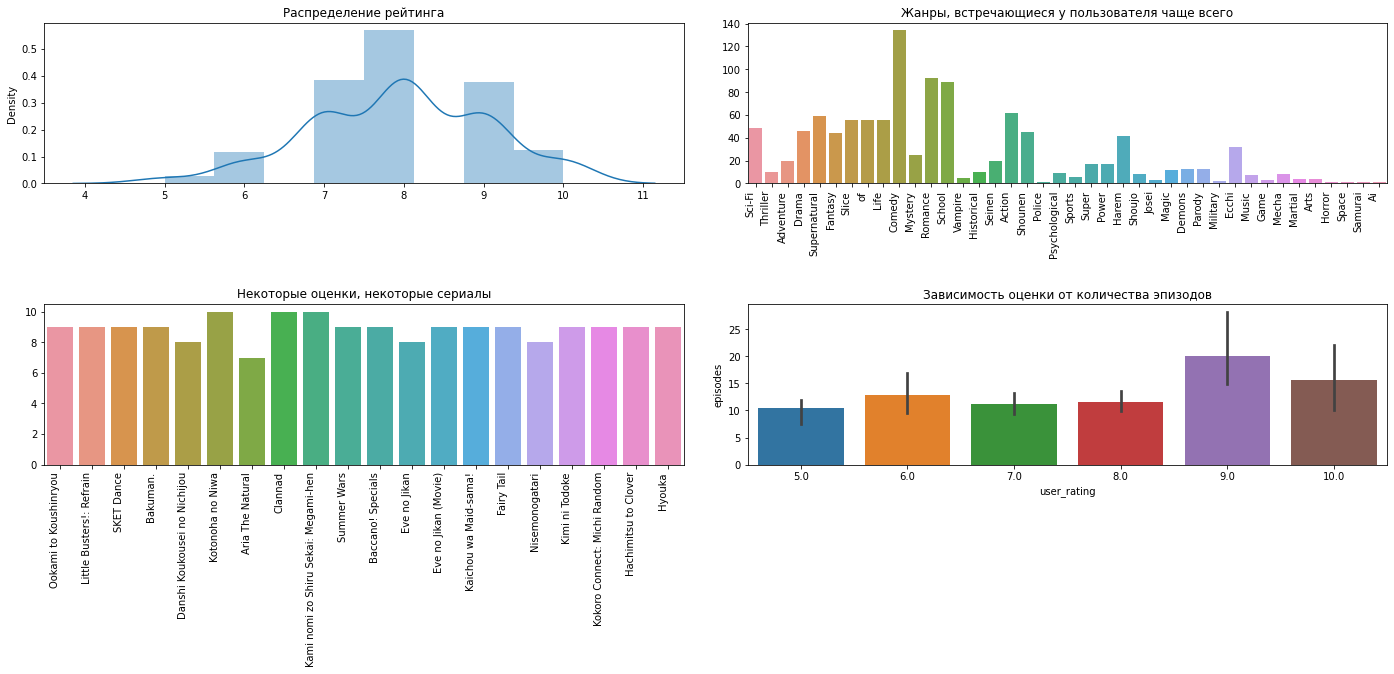

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.distplot(x=user_500['user_rating'], ax=ax[0, 0])
sns.barplot(x=list(gen_freq.keys()), y = list(gen_freq.values()), ax=ax[0, 1])
sns.barplot(x=list(gen_rating.keys())[30:50], y = list(gen_rating.values())[30:50], ax=ax[1, 0])
sns.barplot(y=user_500['episodes'], x=user_500['user_rating'], ax=ax[1, 1])

ax[0, 0].set_title('Распределение рейтинга')
ax[0, 1].set_title('Жанры, встречающиеся у пользователя чаще всего')
ax[1, 0].set_title('Некоторые оценки, некоторые сериалы')
ax[1, 1].set_title('Зависимость оценки от количества эпизодов')

ax[0, 1].set_xticklabels(list(gen_freq.keys()), rotation = 90, ha="right")
ax[1, 0].set_xticklabels(list(gen_rating.keys())[30:50], rotation = 90, ha="right")
fig.tight_layout(pad=3.0)
plt.show()

## Выбор модели

### Кластеризация пользователей

In [5]:
merged_clust.dropna(inplace=True)

In [6]:
rating_mean = rating.groupby(['user_id']).mean().reset_index()
rating_mean['mean_rating'] = rating_mean['rating']
rating_mean.drop(['anime_id','rating'],axis=1, inplace=True)
merged_clust = pd.merge(merged_clust, rating_mean,on=['user_id','user_id'])
merged_clust = merged_clust.drop(merged_clust[merged_clust['user_rating'] < merged_clust['mean_rating']].index)
merged_clust.shape

(3381039, 15)

Преобразовать данные так, чтобы по строкам располагались первые 10000 пользователей (я всё время out of memory), а признаками были аниме - 1, если понравилось, 0, если не посмотрел/не понравилось.

In [25]:
merged_clust.head()

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,anime_id,name,genre,episodes,rating,members,user_id,user_rating,mean_rating
1,0,0,0,0,0,1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",64.0,9.26,793665,99,10.0,5.687023
2,0,0,0,0,0,1,9253,Steins;Gate,"Sci-Fi, Thriller",24.0,9.17,673572,99,9.0,5.687023
3,0,0,0,0,0,1,4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",24.0,9.06,456749,99,10.0,5.687023
4,0,0,0,0,0,1,2904,Code Geass: Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",25.0,8.98,572888,99,9.0,5.687023
5,1,0,0,0,0,0,199,Sen to Chihiro no Kamikakushi,"Adventure, Drama, Supernatural",1.0,8.93,466254,99,9.0,5.687023


In [11]:
merged_clust_ = merged_clust[merged_clust['user_id'] <= 10000]

In [12]:
user_anime = pd.crosstab(merged_clust_['user_id'], merged_clust_['name'])

In [13]:
user_anime.head(2)

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
user_anime.shape

(9467, 6409)

### PCA

In [15]:
model = PCA(n_components=3)
model.fit(user_anime)
pca_samples = model.transform(user_anime)

In [16]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2
0,-1.404983,-0.417371,0.297259
1,-1.565053,-0.175738,-0.007869
2,0.348088,-1.504035,-0.675251
3,3.660935,-0.911004,-0.607187
4,2.643904,-1.243414,0.955136


In [17]:
print(f'Было {user_anime.shape}, стало {ps.shape}')

Было (9467, 6409), стало (9467, 3)


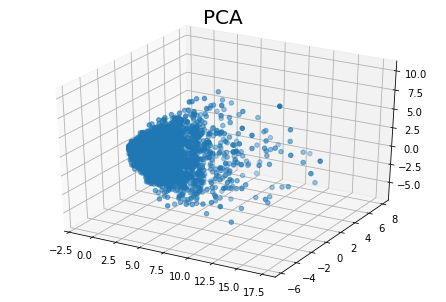

In [18]:
tocluster = pd.DataFrame(ps[[0,1,2]])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('PCA', fontsize=20)
plt.show()

### Кластеризуем

Подберем k по инерции и силуэту:

In [19]:
inertia = [KMeans(n_clusters=k).fit(tocluster).inertia_ for k in range(2,10)]
score = [silhouette_score(tocluster, KMeans(n_clusters=k).fit_predict(tocluster)) for k in range(2,10)]

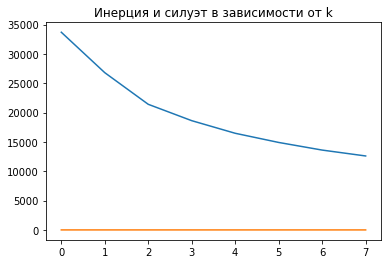

In [21]:
#можно взять 4 кластера, скор 0.5193213666589233
plt.plot(inertia)
plt.plot(score)
plt.title('Инерция и силуэт в зависимости от k');
plt.show()

Вот так подбираю параметры для Gaussian Mixture ('spherical', 'full', 'diag' не очень, пробовала их по отдельности):

In [24]:
n_components_range = range(3, 10)
cv_types = ['tied', 'diag']
hyper = []
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm_pred = gmm.fit_predict(tocluster)
        hyper.append([n_components, cv_type, silhouette_score(tocluster, gmm_pred)])

In [26]:
# только с тремя кластерами лучше, но мне показалось, что это как-то мало
hyper[1]

[4, 'tied', 0.5833563990981827]

In [27]:
kmeans = KMeans(n_clusters=4).fit(tocluster)
gmm = mixture.GaussianMixture(n_components=4, covariance_type='tied').fit(tocluster)

In [28]:
kmeans_pred = kmeans.predict(tocluster)
gmm_pred = gmm.predict(tocluster)

In [29]:
def show_clusters(title, clusters, clusters_predicted):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(clusters[0], clusters[2], clusters[1], c = clusters_predicted)
    plt.title(title)
    plt.show()

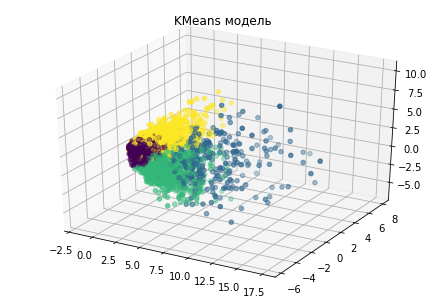

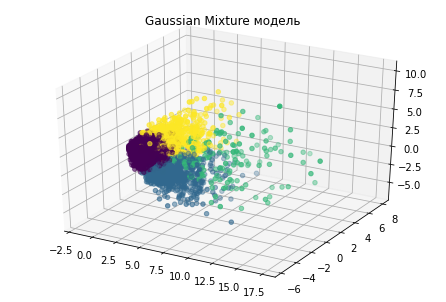

In [30]:
show_clusters('KMeans модель', tocluster, kmeans_pred)
show_clusters('Gaussian Mixture модель', tocluster, gmm_pred)

In [31]:
user_anime['kmeans'] = kmeans_pred
user_anime['gmm'] = gmm_pred

### Что всё это значит?

In [32]:
merged_clust_.set_index(merged_clust_['user_id'], drop=True, inplace=True)
merged_clust_.head(2)

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,anime_id,name,genre,episodes,rating,members,user_id,user_rating,mean_rating
user_id,,,,,,,,,,,,,,,
99,0,0,0,0,0,1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",64.0,9.26,793665,99,10.0,5.687023
99,0,0,0,0,0,1,9253,Steins;Gate,"Sci-Fi, Thriller",24.0,9.17,673572,99,9.0,5.687023


In [33]:
after_clustering = pd.merge(merged_clust_, user_anime[['kmeans', 'gmm']], left_index=True, right_index=True).drop(columns='user_id')
after_clustering.head(2)

,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,anime_id,name,genre,episodes,rating,members,user_rating,mean_rating,kmeans,gmm
user_id,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,15451,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",12.0,7.87,266657,10.0,10.0,0,0
1,0,0,0,0,0,1,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",25.0,7.83,893100,10.0,10.0,0,0


In [34]:
def assign_cluster_vars(method, number):
    return after_clustering[after_clustering[method]==number].drop(columns=['kmeans', 'gmm'])

def assign_cluster_means(method, number):
    return user_anime[user_anime[method]==number].drop(columns=['kmeans', 'gmm']).mean()

In [35]:
print(assign_cluster_means('kmeans', 3).sort_values(ascending=False)[0:15])

name
Code Geass: Hangyaku no Lelouch       0.641716
Death Note                            0.638352
Code Geass: Hangyaku no Lelouch R2    0.603028
Fullmetal Alchemist                   0.534062
Sen to Chihiro no Kamikakushi         0.527334
Suzumiya Haruhi no Yuuutsu            0.503785
Tengen Toppa Gurren Lagann            0.497056
Cowboy Bebop                          0.492010
Neon Genesis Evangelion               0.481077
Mononoke Hime                         0.448276
Fullmetal Alchemist: Brotherhood      0.444071
Toradora!                             0.443230
Howl no Ugoku Shiro                   0.439024
Elfen Lied                            0.438183
Toki wo Kakeru Shoujo                 0.417998
dtype: float64


In [36]:
print(assign_cluster_means('gmm', 0).sort_values(ascending=False)[0:15])
print(assign_cluster_means('gmm', 2).sort_values(ascending=False)[0:15])
print(assign_cluster_means('kmeans', 0).sort_values(ascending=False)[0:15])
print(assign_cluster_means('kmeans', 3).sort_values(ascending=False)[0:15])

name
Death Note                            0.339489
Shingeki no Kyojin                    0.258032
Code Geass: Hangyaku no Lelouch       0.220339
Fullmetal Alchemist: Brotherhood      0.213762
Code Geass: Hangyaku no Lelouch R2    0.200101
Sen to Chihiro no Kamikakushi         0.190488
Sword Art Online                      0.182773
Fullmetal Alchemist                   0.175689
Angel Beats!                          0.155199
Steins;Gate                           0.147103
Elfen Lied                            0.146850
Toradora!                             0.140400
Ouran Koukou Host Club                0.139641
Tengen Toppa Gurren Lagann            0.138755
Howl no Ugoku Shiro                   0.138249
dtype: float64
name
Code Geass: Hangyaku no Lelouch       0.893333
Steins;Gate                           0.853333
Code Geass: Hangyaku no Lelouch R2    0.853333
Bakemonogatari                        0.840000
Toradora!                             0.833333
Suzumiya Haruhi no Yuuutsu         

In [37]:
kmeans_0, kmeans_1, kmeans_2, kmeans_3 = assign_cluster_vars('kmeans', 0), assign_cluster_vars('kmeans', 1), assign_cluster_vars('kmeans', 2), assign_cluster_vars('kmeans', 3)
gmm_0, kmeans_1, gmm_2, gmm_3 = assign_cluster_vars('gmm', 0), assign_cluster_vars('gmm', 1), assign_cluster_vars('gmm', 2), assign_cluster_vars('gmm', 3)

А генератор облачков написал А.Мюллер: https://github.com/amueller/word_cloud

In [52]:
def cloud(name, dictionary):
    wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color="lemonchiffon", 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False).generate_from_frequencies(dictionary)
    plt.title(name)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Сделаю словари для кластеров по жанрам и по названиям (не могу по всему кластеру, циклы for тормозят, а как по-другому написать не знаю):

In [38]:
def freq_dict(df, genres_all):
    for i in df['genre'].values:
        for j in i.split():
            genres_all.append(j.strip(','))

    genres_for_freq = []      
    for i in genres_all:
        word_count = genres_all.count(i)
        genres_for_freq.append((i,word_count))       

    frequency = dict(genres_for_freq)
    return frequency

In [46]:
genres_0_all = []
genres_2_all = []

kmeans_0_frequency = freq_dict(kmeans_0[:10000], genres_0_all)
kmeans_2_frequency = freq_dict(kmeans_2[:10000], genres_2_all)

In [47]:
genres_0_all = []
genres_2_all = []

gmm_0_frequency = freq_dict(gmm_0[:10000], genres_0_all)
gmm_2_frequency = freq_dict(gmm_2[:10000], genres_2_all)

In [48]:
def freq_dict_names(df):
    names_for_freq = []      
    for i in df['name'].values:
        word_count = list(df['name'].values).count(i)
        names_for_freq.append((i,word_count))       

    frequency = dict(names_for_freq)
    return frequency

In [50]:
gmm_0_name_frequency = freq_dict_names(gmm_0[:10000])
gmm_2_name_frequency = freq_dict_names(gmm_2[:10000])
kmeans_0_name_frequency = freq_dict_names(kmeans_0[:10000])
kmeans_2_name_frequency = freq_dict_names(kmeans_2[:10000])

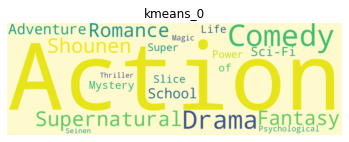

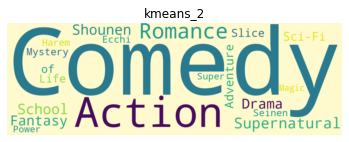

In [53]:
cloud('kmeans_0', kmeans_0_frequency)
cloud('kmeans_2', kmeans_2_frequency)

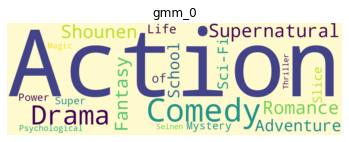

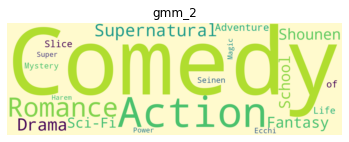

In [54]:
cloud('gmm_0', gmm_0_frequency)
cloud('gmm_2', gmm_2_frequency)

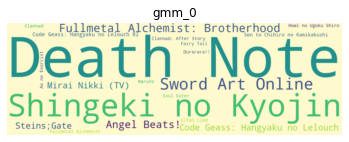

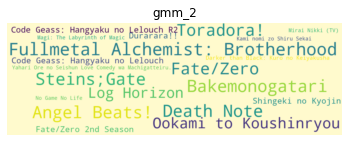

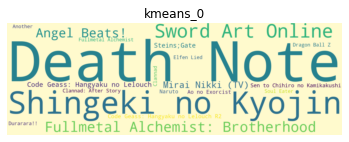

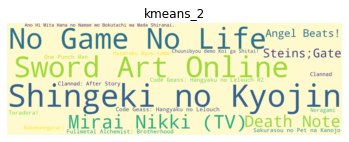

In [55]:
cloud('gmm_0', gmm_0_name_frequency)
cloud('gmm_2', gmm_2_name_frequency)
cloud('kmeans_0', kmeans_0_name_frequency)
cloud('kmeans_2', kmeans_2_name_frequency)